In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

In [2]:
# 1. Load data
DATA_PATH = "complaints.csv.zip" 
df = pd.read_csv(DATA_PATH, compression="zip", low_memory=False)
print("Raw shape:", df.shape)
print("Columns:", df.columns.tolist())

Raw shape: (12126091, 18)
Columns: ['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?', 'Complaint ID']


In [3]:
# 2. Basic cleaning
required_cols = ["Consumer complaint narrative", "Issue"]
for col in required_cols:
    if col not in df.columns:
        raise ValueError(f"Required column '{col}' not found in dataset.")
# Keep only rows with non-null text and non-null Issue
df = df.dropna(subset=["Consumer complaint narrative", "Issue"]).copy()
df = df.rename(columns={"Consumer complaint narrative": "text"})
print("After dropping rows without text or Issue:", df.shape)

After dropping rows without text or Issue: (3524085, 18)


In [4]:
# 3. Map raw Issue into high-level financial complaint categories
def map_issue_to_category(issue: str) -> str:
    s = str(issue).lower()
    # 1) Credit reporting issues
    if (
        "credit report" in s
        or "consumer report" in s
        or "personal consumer reports" in s
        or "your report" in s
    ):
        return "Credit Reporting"
    # 2) Debt collection issues
    if (
        "debt" in s
        or "collect debt" in s
        or "collection" in s
        or "collector" in s
        or "attempts to collect" in s
    ):
        return "Debt Collection"
    # 3) Card / payment / transaction issues
    if (
        "credit card" in s
        or "prepaid card" in s
        or "debit card" in s
        or "card" in s
        or "transaction" in s
        or "purchase" in s
        or "payment" in s
    ):
        return "Card / Payment"
    # 4) Loan / mortgage issues
    if (
        "mortgage" in s
        or "loan" in s
        or "auto loan" in s
        or "vehicle loan" in s
        or "student loan" in s
        or "lender" in s
        or "servicer" in s
    ):
        return "Loan / Mortgage"
    # 5) Fraud / scam
    if "fraud" in s or "scam" in s or "identity theft" in s:
        return "Fraud / Scam"
    # 6) Fees & charges
    if (
        "fee" in s
        or "fees" in s
        or "charged" in s
        or "charges" in s
        or "billing" in s
        or "charge-off" in s
    ):
        return "Fees / Charges"
    # 7) Customer service / communication
    if (
        "customer service" in s
        or "customer relations" in s
        or "communication tactics" in s
        or "communication" in s
    ):
        return "Customer Service"
    # 8) Disclosure / marketing / information
    if (
        "disclosure" in s
        or "advertising" in s
        or "marketing" in s
        or "terms" in s
        or "information provided" in s
    ):
        return "Disclosure / Info"
    # 9) Default fallback
    return "Other"

df["issue_category"] = df["Issue"].apply(map_issue_to_category)

print("\nHigh-level category distribution (before filtering rare classes):")
print(df["issue_category"].value_counts())


High-level category distribution (before filtering rare classes):
issue_category
Credit Reporting     2040019
Other                 623374
Debt Collection       276043
Card / Payment        235797
Loan / Mortgage       176368
Fraud / Scam           55789
Fees / Charges         40862
Disclosure / Info      38044
Customer Service       37789
Name: count, dtype: int64


In [5]:
# 4. Encode labels
lbl = LabelEncoder()
df["issue_label"] = lbl.fit_transform(df["issue_category"])
target_names = lbl.classes_
labels = list(range(len(target_names)))
print("\nLabel mapping:")
for i, c in enumerate(target_names):
    print(f"{i}: {c}")


Label mapping:
0: Card / Payment
1: Credit Reporting
2: Customer Service
3: Debt Collection
4: Disclosure / Info
5: Fees / Charges
6: Fraud / Scam
7: Loan / Mortgage
8: Other


In [6]:
# 5. Train-test split
TEST_SIZE = 0.2  
RANDOM_STATE = 42   

X = df["text"].astype(str)
y = df["issue_label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

print(f"\nTrain size: {len(X_train)}, Test size: {len(X_test)}")


Train size: 2819268, Test size: 704817


In [7]:
# 6. TF-IDF vectorization
tfidf = TfidfVectorizer(
    max_features=20000,    
    ngram_range=(1, 2),    
    min_df=10
)
print("\nFitting TF-IDF...")
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
print("TF-IDF shape:", X_train_tfidf.shape)


Fitting TF-IDF...
TF-IDF shape: (2819268, 20000)


In [8]:
# 7. Evaluation helper
def eval_model(name, model, X_tr, y_tr, X_te, y_te, labels, target_names):
    print(f"\nTraining {name}...")
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    macro_f1 = f1_score(y_te, y_pred, average="macro")
    print(f"\n===== {name} =====")
    print(f"Accuracy : {acc:.4f}")
    print(f"Macro-F1 : {macro_f1:.4f}")
    print("Classification report:")
    print(classification_report(y_te, y_pred, labels=labels, target_names=target_names))
    return acc, macro_f1, y_pred
results = []

In [9]:
# 8. Models: NB, LR, XGBoost
# 8.1 Multinomial Naive Bayes
nb = MultinomialNB()
acc_nb, f1_nb, y_pred_nb = eval_model(
    "TF-IDF + Multinomial NB",
    nb,
    X_train_tfidf,
    y_train,
    X_test_tfidf,
    y_test,
    labels,
    target_names
)
results.append(("TF-IDF + NB", acc_nb, f1_nb))


Training TF-IDF + Multinomial NB...

===== TF-IDF + Multinomial NB =====
Accuracy : 0.6880
Macro-F1 : 0.4811
Classification report:
                   precision    recall  f1-score   support

   Card / Payment       0.61      0.45      0.52     47159
 Credit Reporting       0.86      0.85      0.86    408004
 Customer Service       0.38      0.57      0.46      7558
  Debt Collection       0.51      0.60      0.55     55209
Disclosure / Info       0.27      0.45      0.34      7609
   Fees / Charges       0.31      0.52      0.39      8172
     Fraud / Scam       0.27      0.45      0.34     11158
  Loan / Mortgage       0.35      0.81      0.49     35273
            Other       0.59      0.30      0.40    124675

         accuracy                           0.69    704817
        macro avg       0.46      0.56      0.48    704817
     weighted avg       0.72      0.69      0.69    704817



In [10]:
# 8.2 Logistic Regression
logreg = LogisticRegression(
    max_iter=200,
    n_jobs=-1,
    solver="saga"
)
acc_lr, f1_lr, y_pred_lr = eval_model(
    "TF-IDF + Logistic Regression",
    logreg,
    X_train_tfidf,
    y_train,
    X_test_tfidf,
    y_test,
    labels,
    target_names
)
results.append(("TF-IDF + Logistic Regression", acc_lr, f1_lr))


Training TF-IDF + Logistic Regression...

===== TF-IDF + Logistic Regression =====
Accuracy : 0.7986
Macro-F1 : 0.6131
Classification report:
                   precision    recall  f1-score   support

   Card / Payment       0.69      0.71      0.70     47159
 Credit Reporting       0.87      0.95      0.90    408004
 Customer Service       0.61      0.45      0.52      7558
  Debt Collection       0.67      0.60      0.64     55209
Disclosure / Info       0.66      0.36      0.46      7609
   Fees / Charges       0.62      0.44      0.52      8172
     Fraud / Scam       0.65      0.37      0.48     11158
  Loan / Mortgage       0.69      0.66      0.67     35273
            Other       0.70      0.58      0.63    124675

         accuracy                           0.80    704817
        macro avg       0.68      0.57      0.61    704817
     weighted avg       0.79      0.80      0.79    704817



In [11]:
# 8.3 XGBoost
X_train_xgb = X_train_tfidf
y_train_xgb = y_train
xgb_clf = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=len(target_names),
    learning_rate=0.1,
    n_estimators=100,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    eval_metric="mlogloss",
    n_jobs=-1
)
acc_xgb, f1_xgb, y_pred_xgb = eval_model(
    "TF-IDF + XGBoost",
    xgb_clf,
    X_train_xgb,
    y_train_xgb,
    X_test_tfidf,
    y_test,
    labels,
    target_names
)
results.append(("TF-IDF + XGBoost", acc_xgb, f1_xgb))


Training TF-IDF + XGBoost...

===== TF-IDF + XGBoost =====
Accuracy : 0.7534
Macro-F1 : 0.5270
Classification report:
                   precision    recall  f1-score   support

   Card / Payment       0.68      0.58      0.62     47159
 Credit Reporting       0.80      0.97      0.87    408004
 Customer Service       0.57      0.34      0.42      7558
  Debt Collection       0.60      0.49      0.54     55209
Disclosure / Info       0.70      0.25      0.36      7609
   Fees / Charges       0.57      0.37      0.45      8172
     Fraud / Scam       0.73      0.23      0.36     11158
  Loan / Mortgage       0.64      0.59      0.61     35273
            Other       0.68      0.41      0.51    124675

         accuracy                           0.75    704817
        macro avg       0.66      0.47      0.53    704817
     weighted avg       0.74      0.75      0.73    704817



In [12]:
# 9. Summary table + Macro-F1 bar chart
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Macro_F1"])
print("\n==== Summary of baseline models ====")
print(results_df)

plt.figure(figsize=(8, 4))
plt.bar(results_df["Model"], results_df["Macro_F1"])
plt.ylabel("Macro-F1")
plt.title("Baseline Model Comparison on Financial Complaint Classification")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.savefig("baseline_macro_f1_comparison.png", dpi=300)
plt.close()
print("Saved: baseline_macro_f1_comparison.png")



==== Summary of baseline models ====
                          Model  Accuracy  Macro_F1
0                   TF-IDF + NB  0.687983  0.481136
1  TF-IDF + Logistic Regression  0.798603  0.613059
2              TF-IDF + XGBoost  0.753400  0.526987
Saved: baseline_macro_f1_comparison.png


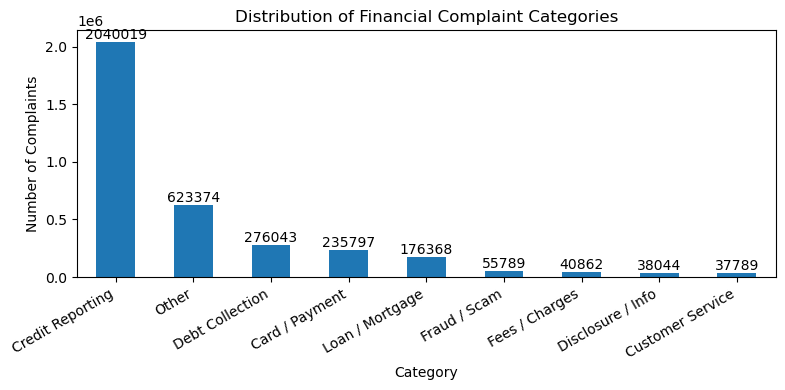

In [19]:
#10.Figures
plt.style.use("default")
FIG_PREFIX = "cfpb_"
# Figure 1: Class distribution 
class_counts = df["issue_category"].value_counts().sort_values(ascending=False)
plt.figure(figsize=(8, 4))
ax = class_counts.plot(kind="bar")
plt.title("Distribution of Financial Complaint Categories")
plt.xlabel("Category")
plt.ylabel("Number of Complaints")
plt.xticks(rotation=30, ha="right")
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{int(height)}",
        (p.get_x() + p.get_width() / 2, height), 
        ha='center', va='bottom',
        fontsize=10
    )
plt.tight_layout()
plt.savefig(FIG_PREFIX + "class_distribution.png", dpi=300)
plt.show()

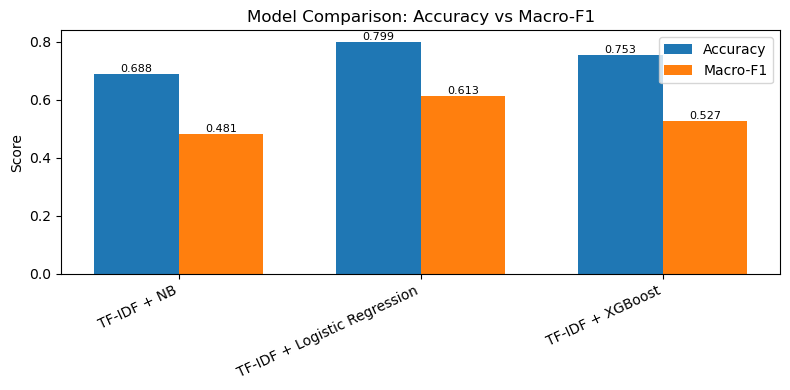

In [20]:
# Figure 2: Model comparison 
x = np.arange(len(results_df["Model"]))
width = 0.35
plt.figure(figsize=(8, 4))
bars_acc = plt.bar(x - width/2, results_df["Accuracy"], width, label="Accuracy")
bars_f1 = plt.bar(x + width/2, results_df["Macro_F1"], width, label="Macro-F1")
for bar in bars_acc:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{height:.3f}",
        ha="center", va="bottom", fontsize=8
    )
for bar in bars_f1:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{height:.3f}",
        ha="center", va="bottom", fontsize=8
    )
plt.xticks(x, results_df["Model"], rotation=25, ha="right")
plt.ylabel("Score")
plt.title("Model Comparison: Accuracy vs Macro-F1")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_PREFIX + "model_comparison_acc_f1.png", dpi=300)
plt.show()

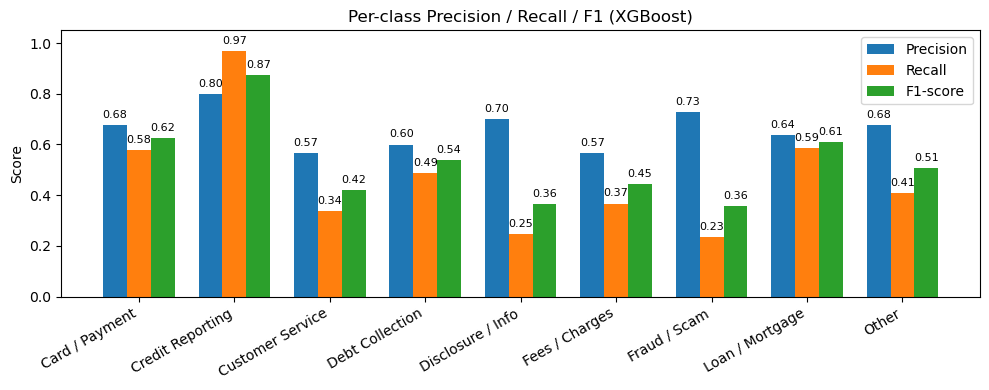

In [22]:
report = classification_report(
    y_test,
    y_pred_xgb,
    target_names=target_names,
    output_dict=True
)
per_class_precision = [report[label]["precision"] for label in target_names]
per_class_recall    = [report[label]["recall"]    for label in target_names]
per_class_f1        = [report[label]["f1-score"]  for label in target_names]

# Figure 3: Per-class Precision / Recall / F1 
indices = np.arange(len(target_names))
width = 0.25
plt.figure(figsize=(10, 4))
bars1 = plt.bar(indices - width, per_class_precision, width, label="Precision")
bars2 = plt.bar(indices,         per_class_recall,    width, label="Recall")
bars3 = plt.bar(indices + width, per_class_f1,        width, label="F1-score")
plt.xticks(indices, target_names, rotation=30, ha="right")
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Per-class Precision / Recall / F1 (XGBoost)")
plt.legend()
plt.tight_layout()
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.02,
            f"{height:.2f}",
            ha="center",
            va="bottom",
            fontsize=8
        )
add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)
plt.savefig(FIG_PREFIX + "per_class_prf_xgb.png", dpi=300)
plt.show()

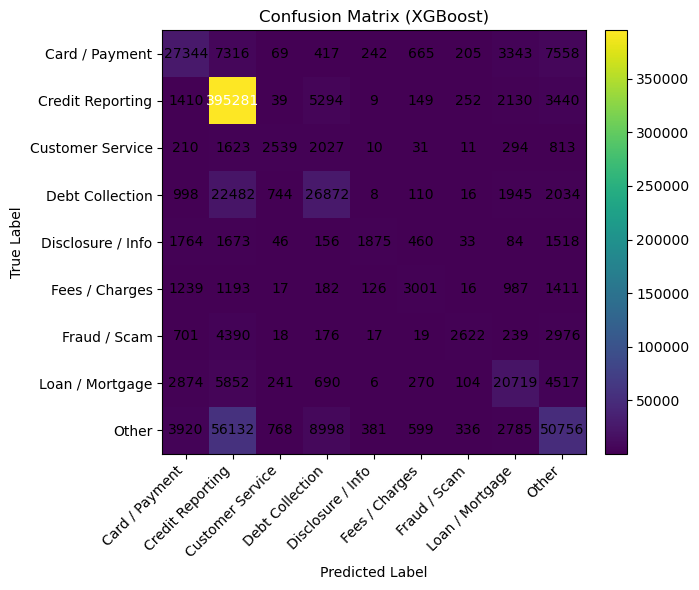

In [17]:
# Figure 4: Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(7, 6))
im = plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (XGBoost)")
plt.colorbar(im, fraction=0.046, pad=0.04)
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45, ha="right")
plt.yticks(tick_marks, target_names)
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, format(cm[i, j], 'd'),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.savefig(FIG_PREFIX + "confusion_matrix_xgb.png", dpi=300)
plt.show()

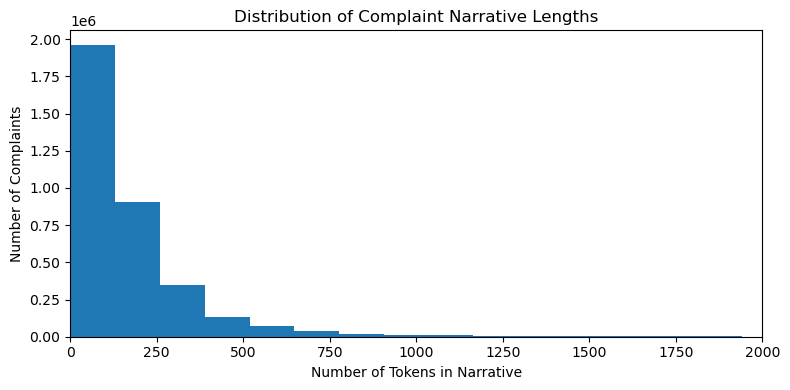

In [23]:
# Figure 5: Distribution of Complaint Narrative Lengths 
text_lengths = df["text"].astype(str).apply(lambda s: len(s.split()))
plt.figure(figsize=(8, 4))
plt.hist(text_lengths, bins=50)
plt.title("Distribution of Complaint Narrative Lengths")
plt.xlabel("Number of Tokens in Narrative")
plt.ylabel("Number of Complaints")
plt.xlim(0, 2000)
plt.tight_layout()
plt.savefig(FIG_PREFIX + "text_length_hist.png", dpi=300)
plt.show()

<Figure size 800x400 with 0 Axes>

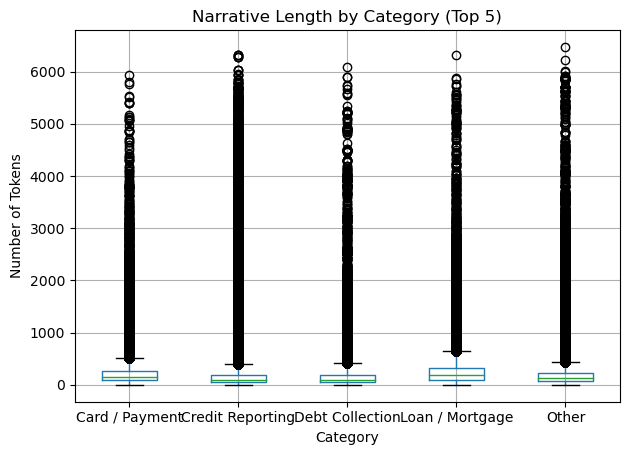

In [24]:
# Figure 6: Narrative Length by Category 
top_cats = class_counts.index[:5]
df_length = df.copy()
df_length["text_len"] = text_lengths
plt.figure(figsize=(8, 4))
df_length[df_length["issue_category"].isin(top_cats)].boxplot(
    column="text_len",
    by="issue_category"
)
plt.title("Narrative Length by Category (Top 5)")
plt.suptitle("")
plt.xlabel("Category")
plt.ylabel("Number of Tokens")
plt.tight_layout()
plt.savefig(FIG_PREFIX + "text_length_boxplot_top5.png", dpi=300)
plt.show()